# Evaluation of a DSB model

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from diffusion.dsb import DiffusionSchrodingerBridge
from image_datasets.capsSlicesADNI import get_ADNI_datasets
from utils.config import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
task = "ADNI_AD_CN"
num = "12"

expe_dir = Path(f"experiments/{task}/dsb{num}")

dsb_param = dsb_config_from_toml(expe_dir / "config.toml")
datasets = get_ADNI_datasets(task)

dsb = DiffusionSchrodingerBridge(
    experiment_directory = expe_dir,
    dsb_params = dsb_param,
    datasets = datasets,
    transfer = True,
    evaluation = True,
)
dsb.device

'cuda'

In [3]:
from image_datasets.capsSlicesADNI import get_dataset_val_hypo
dataset_val = get_dataset_val_hypo()
val_dl = DataLoader(
    dataset_val,
    batch_size=64,
)

## Compute metrics

In [4]:
from evaluation import compute_metrics

In [5]:
n_ipf = 2
num_iter = 5000
fb = 'b'

tsv_path = compute_metrics(dsb, val_dl, n_ipf, num_iter, fb)

/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [6]:
df = pd.read_csv(tsv_path, sep="\t")
print(df)

        participant_id session_id  slice_id metric       image_X      value
0     sub-ADNI002S5256   ses-M000        54    MSE         input   0.016615
1     sub-ADNI002S5256   ses-M000        54   SSIM         input   0.628197
2     sub-ADNI002S5256   ses-M000        54   PSNR         input  23.815545
3     sub-ADNI002S5256   ses-M000        54    MSE  ground_truth   0.027607
4     sub-ADNI002S5256   ses-M000        54   SSIM  ground_truth   0.555526
...                ...        ...       ...    ...           ...        ...
2995  sub-ADNI941S1195   ses-M000        73   SSIM         input   0.553235
2996  sub-ADNI941S1195   ses-M000        73   PSNR         input  21.888471
2997  sub-ADNI941S1195   ses-M000        73    MSE  ground_truth   0.042031
2998  sub-ADNI941S1195   ses-M000        73   SSIM  ground_truth   0.443985
2999  sub-ADNI941S1195   ses-M000        73   PSNR  ground_truth  19.784941

[3000 rows x 6 columns]


In [7]:
import seaborn as sns

sns.boxplot(df, x='value', y='image_X')

<Axes: xlabel='value', ylabel='image_X'>

In [8]:
df[df['image_X']=='ground_truth'].value.mean()

7.042982388710198

### Make latex table

## Make residual plots

In [9]:
from evaluation.visualisation import *

In [10]:
n_ipf = 2
num_iter = 5000
fb = 'b'

dsb.load_checkpoints(n_ipf, num_iter, fb=fb)

In [11]:
batch = next(iter(val_dl))
image = batch['image'][10].unsqueeze(dim=0)

samples = dsb.sample_batch(image, fb)

In [13]:
plot_dir = expe_dir / "evaluation"
plot_dir.mkdir(parents=True, exist_ok=True)
make_diff_plot(
    image.squeeze().cpu(),
    samples[0][-1].squeeze().cpu(),
    batch['label'][10].squeeze().cpu(),
    plot_file = plot_dir / f"diff_plot_{fb}.pdf",
)

In [14]:
from skimage.metrics import structural_similarity as ssim
x = image.squeeze().cpu().numpy()
y = samples[0][-1].squeeze().cpu().numpy()
gt = batch['label'][10].squeeze().cpu().numpy()

print(ssim(x, y, data_range=2))
print(ssim(gt, y, data_range=2))

0.5856272821046019
0.4735101305291139


## Make trajectory plots

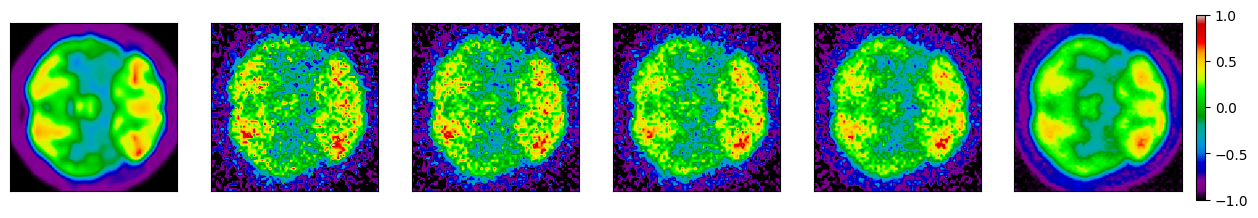

In [8]:
plot_dir = expe_dir / "evaluation"
plot_dir.mkdir(parents=True, exists_ok=True)
make_traj_plot(
    image.squeeze().cpu(),
    samples[0],
    expe_dir = plot_dir / f"trajectory_{fb}.pdf",
)

## Tests

In [ ]:
dataset_val_hypo, dataset_val_cn = get_ADNI_validation()

val_dl_f = DataLoader(
    dataset_val_hypo,
    batch_size=20,
    shuffle=False,
    #num_workers=8,
    drop_last=True,
)
val_dl_b = DataLoader(
    datasets["val_final"],
    batch_size=64,
    shuffle=False,
    #num_workers=8,
    drop_last=True,
)

In [ ]:
batch = next(iter(val_dl_b))
image = batch['image'][10].unsqueeze(dim=0)
    
samples = dsb.sample_batch(image, 'b')

make_diff_plot(
    img_in = image.squeeze().cpu(),
    img_out = samples[0][-1].squeeze().cpu(),
    img_ref = slice_transformations(tensor_img[:,:,:,64]).squeeze().cpu(),
)

In [13]:
import nibabel as nib
CAPS_ADNI = Path("/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025")

a = nib.load(CAPS_ADNI / "masks" / f"mask_hypo_ad_resampled.nii")
a.get_fdata().dtype

dtype('<f8')

In [8]:
import torch
import numpy as np

a = torch.load(
    "/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025" \
    "/subjects/sub-ADNI002S0729/ses-M048/deeplearning_prepare_data/image_based/pet_linear" \
    "/sub-ADNI002S0729_ses-M048_trc-18FFDG_rec-coregiso_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt"
)
a.shape

torch.Size([1, 169, 208, 179])

In [18]:
import nibabel as nib
from nilearn.image import resample_to_img
CAPS_ADNI = Path("/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025")

pathologies = ["ad","bvftd","pca","svppa","lvppa","nfvppa"]

ref_img_path = (
    CAPS_ADNI 
    / "subjects"
    / "sub-ADNI002S0729"
    / "ses-M048"
    / "pet_linear"
    / "sub-ADNI002S0729_ses-M048_trc-18FFDG_rec-coregiso_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.nii.gz"
)
ref_image = nib.load(ref_img_path)

for p in pathologies:
    mask_path = CAPS_ADNI / "masks" / f"mask_hypo_{p}.nii"
    mask_nii = nib.load(mask_path)
    resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
    resampled_mask_nii.to_filename(CAPS_ADNI / "masks" / f"mask_hypo_{p}_resampled.nii")

/tmp/xpython_299575/3818471017.py:20: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
/linkhome/rech/genysv01/usy14zi/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/tmp/xpython_299575/3818471017.py:20: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
/linkhome/rech/genysv01/usy14zi/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:8

In [19]:
mask_nii = nib.load(CAPS_ADNI / "masks" / f"mask_hypo_ad_resampled.nii")

In [20]:
print(mask_nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 169 208 179   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -84.0
qoffset_y       : -119.0
qoffset_z       : -78.0
srow_x          : [  1.   0.   0. -84.]
srow_y  